# **Preprocesamiento de imágenes**

El presente notebook tiene como objetivo el preprocesar las imágenes de ultrasonido antes de incorporarlas en el entrenamiento y evaluación de la inteligencia artificial.

## Resumen

Como ya se comentó en el archivo README.md, las imágenes de ultrasonido son en su totalidad capturas de pantallas del software donde se visualizan. Generalmente estas capturas de pantalla las generan los radiólogos para poder hacer apuntes o marcas que ayuden al diagnóstico por parte del médico. Si bien se podría hacer un uso completo de todas las imágenes, la información del software que se cuela en la captura de pantalla podría ser irrelevante en el entrenamiento y de momento no se tiene claro que tanto lo podría alterar, por lo cuál a través de OpenCV (cv2) se detectaron los bordes de la imagen para generar el recorte. 

Este procesamiento consta de **4** códigos
- **select_1.py**: Se encarga de tomar todas las imágenes de las que se dispone, hacer un primer filtrado a una carpeta 'selection' con 3 subcarpetas:
    ```
    selection
        con_info: Guarda las imágenes que si tienen diagnóstico
        no_apendice: Guarda las imágenes donde no es posible ver el apéndice
        no_paciente: No se poseen los datos necesarios para clasificar estas imágenes
    ```
    
- **crop_2.py**: Toma las imágenes de la subcarpetas 'con_info' y 'no_apendice', las recorta con identificación de bordes y los resultados los envía a las siguientes carpeta y subcarpetas:
    ```
    recortes 
        con_info: Guarda las imágenes recortadas que si tienen diágnóstico

    ordenadas
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
    ```

- **select_3.py**: Toma todas las imágenes de la carpeta 'recortes' y las organiza en la carpeta 'ordenadas'
    ```
    ordenadas
        apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue apendicitis
        no_apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue NO apendicitis
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
    ```

- **ia_data_4.py**: análisis de los resultados de las imágenes.
- **ia_data_5.py**: balanceo de las imágenes, normalización, reshape, vectorización y disposición de la info lista para utilizar en la ia.


Es importante resaltar que todos estos códigos tuvieron que correrse localmente, pues su uso en colab suele ser más lento, dificultando el proceso de desarrollo. Una vez creadas las carpetas (deben estar vacías) que deben ser muy parecidas a las estructuradas en este repositorio, se deben correr los código en el orden marcado para evitar problemas. 




# Metodología

## Primer filtrado

Son 2097 imágenes, pero se deben clasificar haciendo uso de los datos estructurados. 

### Carpetas:

Se encarga de tomar todas las imágenes de las que se dispone, hacer un primer filtrado a una carpeta 'selection' con 3 subcarpetas:

```
    selection
        con_info: Guarda las imágenes que si tienen diagnóstico
        no_apendice: Guarda las imágenes donde no es posible ver el apéndice
        no_paciente: No se poseen los datos necesarios para clasificar estas imágenes
```   
    

In [ ]:
# select_1.py

'''
Con este código se pretenden seleccionar las imágenes que cuenten
con información suficiente para poder entrenar el modelo

El resultado de este código entrará al código 'crop.py'
para recortar cada una de las imágenes. 
'''

# Importar las librerías necesarias
import pandas as pd
import os
import re
import traceback
import shutil

# Ruta del archivo de la base de datos estructurada
file_path = r'C:\Users\alema\Desktop\Dataset original\app_data.xlsx'

# Cargar la primera hoja del archivo Excel en un DataFrame
df = pd.read_excel(file_path, sheet_name=0)

# Columnas seleccionadas
seleccion = ['Appendix_on_US', 'US_Number', 'Diagnosis']

# Especificar las filas (todas) y columnas (seleccion) que se copiaran
df_filtered = df.loc[:, seleccion]


# Función para extraer el número del nombre del archivo con ayuda
# de las funciones regulares
def extract_number(filename):
    match = re.match(r"(\d+)", filename)
    return int(match.group(1)) if match else None


# Rutas de las carpetas de las imágenes originales y destino de los recortes
folder_path = r'C:\Users\alema\Desktop\Dataset original\US_Pictures' # Originales
con_info = r'C:\Users\alema\Desktop\monografia\selection\con_info' # Imágenes usables
no_apendice = r'C:\Users\alema\Desktop\monografia\selection\no_apendice' # Imágenes sin apéndice
no_paciente = r'C:\Users\alema\Desktop\monografia\selection\no_paciente' # Imágenes no usables


# Procesar cada archivo de imagen en la carpeta de entrada
for filename in os.listdir(folder_path):
    # Revisión que el archivo si corresponda a una imagen
    if filename.lower().endswith(('.png', '.bmp', '.jpeg', '.jpg', '.tif')):
        number = extract_number(filename) # número entero del archivo

        # Se busca en la base de datos filtrada si el número existe y se guardan
        # todos los valores de su fila
        fila_correspondiente = df_filtered.loc[df_filtered['US_Number'] == number]

        try:
            # Verifica que el número y la lista si existan
            if number is not None and fila_correspondiente.empty != True:

                # Revisa si el apendice aparece en la imagen
                if fila_correspondiente['Appendix_on_US'].iloc[0] == 'yes':

                    # Revisa si el diagnóstico es appendicitis o sin esta
                    if fila_correspondiente['Diagnosis'].iloc[0] == 'appendicitis' or\
                    fila_correspondiente['Diagnosis'].iloc[0] == 'no appendicitis':
                        target_folder = con_info

                    # Imágenes que no sirven en el entrenamiento
                    else:
                        target_folder = no_paciente
                
                # Imágenes donde no se ve el apéndice
                else: 
                    target_folder = no_apendice

            # Imágenes cuyos pacientes NO existen en la base de datos
            else:
                target_folder = no_paciente

            # Determinar la carpeta de destino y mover el archivo
            shutil.move(os.path.join(folder_path, filename),
                        os.path.join(target_folder, filename))

        except Exception as e:
            # Si hay un error, imprimirlo y continuar con la siguiente imagen
            print(f"No se pudo procesar el archivo: {filename}: {e}")
            traceback.print_exc() # Imprime el tipo de error

## Recorte

Aquí se hace uso de la identificación de bordes y se especifica que se descarten aquellos bordes menores a 250 pixeles y cuyo lado más  largo sea mayor a 1.5 veces el lado más corto. Esto evita que se recorten pequeños cuadros que hay en las capturas de pantalla.

### Carpetas:
Toma las imágenes de la subcarpetas 'con_info' y 'no_apendice', las recorta con identificación de bordes y los resultados los envía a las siguientes carpeta y subcarpetas:
    
```
    recortes 
        Guarda las imágenes recortadas que si tienen diágnóstico

    ordenadas
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
 ```


In [ ]:
# crop.py

import cv2
import os

def ajustar_niveles(imagen, nivel_min, nivel_max):
    """
    Ajusta los niveles de la imagen utilizando cv2.normalize.
    """
    return cv2.normalize(imagen, None, alpha=nivel_min, beta=nivel_max, norm_type=cv2.NORM_MINMAX)

def encontrar_y_recortar_imagen(input_path, output_path):
    """
    Encuentra la imagen de ultrasonido dentro de una captura de pantalla y la recorta
    sin modificar el brillo y el contraste en la imagen recortada.
    """
    # Leer la imagen original
    imagen_original = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    
    # Ajustar los niveles de la imagen para mejorar el contraste
    imagen_contrastada = ajustar_niveles(imagen_gris, 0, 255)
    
    # Umbralizar la imagen para obtener una binarización
    _, imagen_binaria = cv2.threshold(imagen_contrastada, 1, 255, cv2.THRESH_BINARY)
    
    # Encontrar los contornos en la imagen binaria
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Procesar cada contorno encontrado
    for contorno in contornos:
        # Calcular el rectángulo delimitador para el contorno
        x, y, ancho, alto = cv2.boundingRect(contorno)
        borde_mas_corto = min(ancho, alto)
        borde_mas_largo = max(ancho, alto)
        proporcion = borde_mas_largo / borde_mas_corto

        # Comprobar si el contorno cumple con las condiciones de tamaño mínimo y proporción
        if borde_mas_corto >= 250 and proporcion <= 1.5:
            # Recortar la imagen original (sin ajustes de contraste) según el contorno que cumple con los requisitos
            imagen_recortada = imagen_original[y:y+alto, x:x+ancho]
            
            # Guardar la imagen recortada
            cv2.imwrite(output_path, imagen_recortada)
            break  # Terminar después de procesar el primer contorno válido

# Rutas de las carpetas de las imágenes originales y destino de los recortes
## Para LAs que tienen diagnóstico
input_folder1 = r'C:\Users\alema\Desktop\monografia\selection\con_info'
output_folder1 = r'C:\Users\alema\Desktop\monografia\recortes\con_info'

## Para las que no tienen apéndice en la imagen
input_folder2 = r'C:\Users\alema\Desktop\monografia\selection\no_apendice'
output_folder2 = r'C:\Users\alema\Desktop\monografia\ordenadas\no_apendice'

# Procesar cada archivo de imagen en la carpeta de entrada
def ubicar(input_folder, output_folder):
    '''
    Esta función permite a unas rutas dadas tomar las fotos que allí
    se encuentran, recortarlas y moverlas a otra ubicación
    '''
    for filename in os.listdir(input_folder):
        try:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                input_path = os.path.join(input_folder, filename)
                base_name = os.path.splitext(filename)[0] + '.png'  # Cambiar la extensión a .png
                output_path = os.path.join(output_folder, base_name)
                
                # Intentar procesar la imagen
                try:
                    encontrar_y_recortar_imagen(input_path, output_path)
                except Exception as e:
                    print(f"No se pudo procesar el archivo {filename}: {e}")
        except Exception as e:
            print(f"No se pudo procesar el archivo {filename}: {e}")

# Procesar imágenes con diagnóstico
ubicar(input_folder1, output_folder1)

# Procesar imágenes sin apendice
ubicar(input_folder2, output_folder2)


## Ordenar
Hasta el momento solo se tienen ordenadas las imágenes donde el apendice no es visible, pero esto se resuelve con los siguientes códigos.

### Carpetas
Toma todas las imágenes de la carpeta 'recortes' y las organiza en la carpeta 'ordenadas'

```
    ordenadas
        apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue apendicitis
        no_apendicitis: Guarda las imágenes recortadas donde se ve el apéndice y el diagnóstico fue NO apendicitis
        no_apendice: Guarda directamente las imágenes recortadas que sabemos que no muestra el apendice.
```

In [ ]:
# select_3.py

import os # Para navegar por las carpetas de colab
import re # Para trabajar con expresiones regulares
import shutil # Para cambiar los archivos de ubicación
import traceback # Para usar con try except
import pandas as pd


# Ruta del archivo de la base de datos estructurada
file_path = r'C:\Users\alema\Desktop\Dataset original\app_data.xlsx'

# Cargar la primera hoja del archivo Excel en un DataFrame
df = pd.read_excel(file_path, sheet_name=0)

# Columnas seleccionadas
seleccion = ['Appendix_on_US', 'US_Number', 'Diagnosis']

# Especificar las filas (todas) y columnas (seleccion) que se copiaran
df_filtered = df.loc[:, seleccion]


# Ruta a la carpeta donde están las imágenes sin ordenar
folder_path = r'C:\Users\alema\Desktop\monografia\recortes\con_info'

# Rutas a las carpetas donde se ordenarán las imágenes
apendicitis = r'C:\Users\alema\Desktop\monografia\ordenadas\apendicitis'
no_apendicitis = r'C:\Users\alema\Desktop\monografia\ordenadas\no_apendicitis'
no_apendice = r'C:\Users\alema\Desktop\monografia\ordenadas\no_apendice'
no_classification = r'C:\Users\alema\Desktop\monografia\ordenadas\no_classification'
no_id = r'C:\Users\alema\Desktop\monografia\ordenadas\no_id'

# Función para extraer el número del nombre del archivo con ayuda
# de las funciones regulares
def extract_number(filename):
    match = re.match(r"(\d+)", filename)
    return int(match.group(1)) if match else None

# Procesar cada archivo en la carpeta
count = 0 # Para poder almacenar los resultados en df_results
for filename in os.listdir(folder_path):
    # Revisión que el archivo si corresponda a una imagen
    if filename.lower().endswith(('.png', '.bmp', '.jpeg', '.jpg', '.tif')):
        number = extract_number(filename) # número entero del archivo

        # Se busca en la base de datos filtrada si el número existe y se guardan
        # todos los valores de su fila
        fila_correspondiente = df_filtered.loc[df_filtered['US_Number'] == number]

        try:

            # Revisa si el diagnóstico es appendicitis o sin esta
            if fila_correspondiente['Diagnosis'].iloc[0] == 'no appendicitis':
                target_folder = no_apendicitis

            else:
                target_folder = apendicitis

            # Determinar la carpeta de destino y mover el archivo
            shutil.move(os.path.join(folder_path, filename),
                        os.path.join(target_folder, filename))

        except Exception as e:
            # Si hay un error, imprimirlo y continuar con la siguiente imagen
            print(f"No se pudo procesar el archivo: {filename}: {e}")
            traceback.print_exc() # Imprime el tipo de error

Finalizando esta etapa, se procedió a revisar los resultados y limpiar manualmente un par de imágenes que parecían no ser importantes. 

## Procesamiento

De aquí en adelante lo que procura es generar una base de datos con las imágenes la cual pueda ser usada para el entrenamiento del modelo a desarrollar.

Este preprocesamiento de imágenes debe ir orientado al modelo que se piensa desarrollar y para ello es importante recordar que la propuesta de este trabajo es el uso de redes neuronales convolucionales, pero cuando se crea una red neuronal nueva todos sus parámetros inician de manera totalmente aleatoria y mediante el entrenamiento se ajustan gradualmente, el problema radica en que en este caso se cuenta únicamente con cientos de datos lo que dificulta este proceso y aumenta el riesgo de caer en sobreajuste.

Por lo anterior se buscará hacer un proceso de "transferencia de aprendizaje" es decir, tomar un modelo que sea bueno reconociendo imágenes de cualquier tipo y entrenarlo sobre este set. Se pretende usar [MobileNetV2](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5) donde se descartarían todas las salidas existentes del modelo (1001 clasificaciones), es decir, la útima capa, para remplazarla por otra con 3 clasificaciones ('sin apendice', 'apendicitis', 'no_apendicitis') y se entrenarían solo las últimas capas del modelo (sin tocar las otras), posteriormente se podrían entrenar todas las capas, pero con una tasa de aprendizaje muy baja. Esta entrega no pretende profundizar más sobre esa metodología, pero se deseaba que el lector comprendiese el camino a tomar en futuras entregas.

### Cuantificación
Antes del procesamiento de las imágenes, se debe generar una cuantificación de estas dependiendo su categoría con el fin de identificar desbalanceos. 

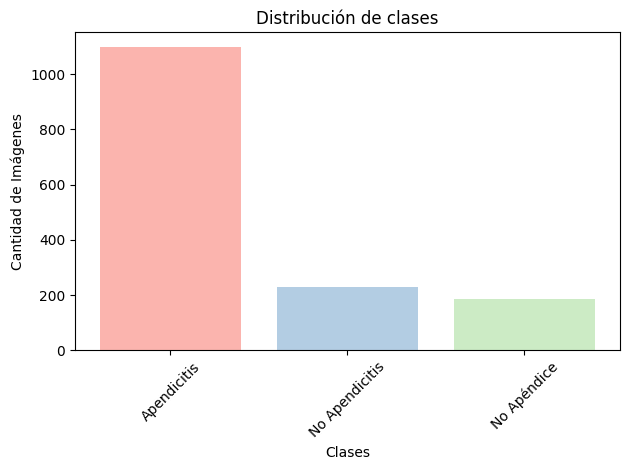


    Apendicitis: 1097, 
    No Apendicitis: 231,
    No Apéndice: 186



In [3]:
# ia_data_4.py

import pandas as pd
import os
import matplotlib.pyplot as plt

# Rutas de archivos
apendicitis = os.listdir(r'C:\Users\alema\Desktop\monografia\ordenadas\apendicitis')
no_apendice = os.listdir(r'C:\Users\alema\Desktop\monografia\ordenadas\no_apendice')
no_apendicitis = os.listdir(r'C:\Users\alema\Desktop\monografia\ordenadas\no_apendicitis')

# Conteo de archivos en cada categoría
count = {
    'Apendicitis': len(apendicitis), 
    'No Apendicitis': len(no_apendicitis),
    'No Apéndice': len(no_apendice)
}

# Crear un DataFrame a partir del diccionario
df = pd.DataFrame(list(count.items()), columns=['Clase', 'Cantidad'])

# Colores pastel
colors = plt.cm.Pastel1.colors

# Crear un gráfico de barras
plt.bar(df['Clase'], df['Cantidad'], color = colors)
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de clases')
plt.xticks(rotation=45)  # Rotar las etiquetas si son demasiado largas
plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama
plt.show()

# Información para balancear
print(f'''
    Apendicitis: {len(apendicitis)}, 
    No Apendicitis: {len(no_apendicitis)},
    No Apéndice: {len(no_apendice)}
''')

El dataset está desbalanceado, por ende se opta por eliminar aleatoriamente instancias de la clase mayoritaria (Undersampling)

In [5]:
# ia_data_5.py

import os
import random
from shutil import copy2

# Ruta a la carpeta donde están tus imágenes de la clase 1
folder_path = r'C:\Users\alema\Documents\Repositorios\datos_monografia\us_images\procesadas\ordenadas\apendicitis'

# Número deseado de muestras después del submuestreo
desired_samples = 250

# Listar todos los archivos de imagen en la carpeta
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Seleccionar un subconjunto aleatorio de archivos
selected_files = random.sample(all_files, desired_samples)

# Eliminar los archivos que no han sido seleccionados si quieres que solo permanezcan los seleccionados en la carpeta original
for file_name in all_files:
    if file_name not in selected_files:
        os.remove(os.path.join(folder_path, file_name))

print(f'La cantidad de imágenes de la carpeta apendicitis es: {len(os.listdir(folder_path))}')

La cantidad de imágenes de la carpeta apendicitis es: 250


Se repite el histograma para asegurar que se hayan balanceado las imágenes

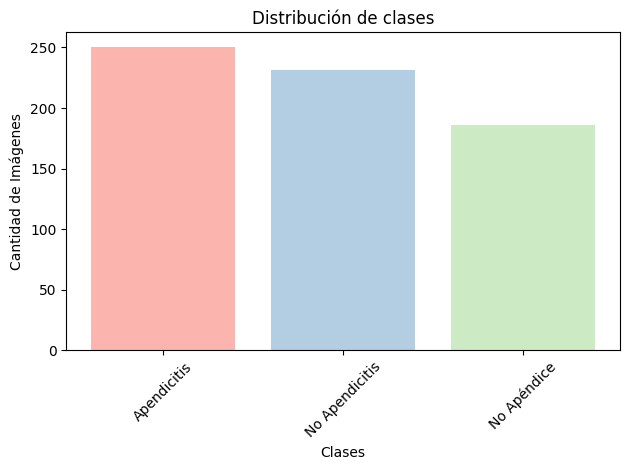


    Apendicitis: 250, 
    No Apendicitis: 231,
    No Apéndice: 186



In [7]:
# ia_data_4.py

import pandas as pd
import os
import matplotlib.pyplot as plt

# Rutas de archivos
apendicitis = os.listdir(r'C:\Users\alema\Documents\Repositorios\datos_monografia\us_images\procesadas\ordenadas\apendicitis')
no_apendice = os.listdir(r'C:\Users\alema\Documents\Repositorios\datos_monografia\us_images\procesadas\ordenadas\no_apendice')
no_apendicitis = os.listdir(r'C:\Users\alema\Documents\Repositorios\datos_monografia\us_images\procesadas\ordenadas\no_apendicitis')

# Conteo de archivos en cada categoría
count = {
    'Apendicitis': len(apendicitis), 
    'No Apendicitis': len(no_apendicitis),
    'No Apéndice': len(no_apendice)
}

# Crear un DataFrame a partir del diccionario
df = pd.DataFrame(list(count.items()), columns=['Clase', 'Cantidad'])

# Colores pastel
colors = plt.cm.Pastel1.colors

# Crear un gráfico de barras
plt.bar(df['Clase'], df['Cantidad'], color = colors)
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de clases')
plt.xticks(rotation=45)  # Rotar las etiquetas si son demasiado largas
plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama
plt.show()

# Información para balancear
print(f'''
    Apendicitis: {len(apendicitis)}, 
    No Apendicitis: {len(no_apendicitis)},
    No Apéndice: {len(no_apendice)}
''')

Es evidente que sigue habiendo un desbalanceo en los datos, pero es algo con lo que se puede trabajar. 

## Aumento de datos

Para evitar que el modelo se aprenda las imágenes en el entrenamiento, generamos varios cambios como rotaciones, zoom, entre otros. 
Este proceso ayudará a que el modelo pueda reconocer las imagenes sin importar su rotación, algo importante puesto que el dataset no fue organizado debidamente y las impagenes no están marcadas como ecografías longitudinales o transversales.

Found 534 images belonging to 3 classes.


Found 133 images belonging to 3 classes.


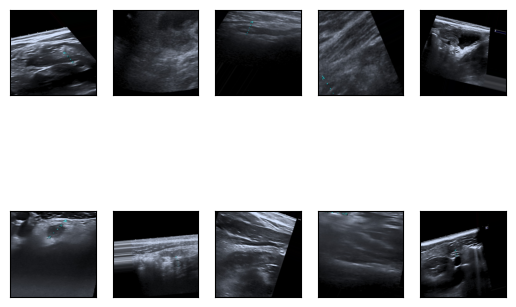

In [3]:
# Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Se instancia un objeto de la clase ImageDataGenerator, el cual aplicará 
# transformaciones en las imágenes para aumentar la variedad de datos.
datagen = ImageDataGenerator(
    rescale=1. / 255,  # Normalizar: Reescalar los valores de los píxeles para que estén entre 0 y 1
    rotation_range = 30, # Rango de grados para rotaciones aleatorias de las imágenes.
    width_shift_range=0.25, # Rango (como fracción del total) para traslados horizontales aleatorios.
    height_shift_range=0.25, # Rango (como fracción del total) para traslados verticales aleatorios.
    shear_range=15, # Intensidad de corte para aplicar cortes aleatorios en las imágenes.
    zoom_range=[0.5, 1.5], # Rango para aplicar zoom aleatorio. 
    validation_split=0.2 # Porcentaje de los datos que se reservará para el conjunto de validación.
)

# Ubicación de las imágenes ordenadas
database = r'C:\Users\alema\Documents\Repositorios\datos_monografia\us_images\procesadas\ordenadas'

# Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory(database, target_size=(300,300),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory(database, target_size=(300,300),
                                                     batch_size=32, shuffle=True, subset='validation')

# Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

Finalmente nuestro set de entrenamiento y prueba está listo!